**脑部MRI分割系统项目需求文档**

------------------------------------------------------------------------

#### **1. 项目概述**

**目标**：开发一个端到端的脑部MRI肿瘤分割系统，实现从数据预处理到模型训练评估的全流程

**核心价值**：

-   为医学影像分析提供可复现的深度学习基准方案
-   验证U-Net在脑肿瘤分割任务中的有效性
-   输出可直接用于临床研究的模型和可视化结果

#### **2. 功能需求**

##### **2.1 数据预处理模块**

| 功能       | 技术指标                                             |
|------------|------------------------------------------------------|
| 数据加载   | 支持`kaggle_3m`数据集格式，自动匹配图像-掩膜对       |
| 数据过滤   | 剔除空白掩膜样本（肿瘤面积为0的病例）                |
| 数据增强   | 标准化Resize(256×256) + ToTensor转换                 |
| 数据集划分 | 按8:2比例分割训练集/验证集，固定随机种子保证可复现性 |

##### **2.2 深度学习模型**

| 组件     | 参数规格                       |
|----------|--------------------------------|
| 网络架构 | 经典U-Net：4层编码器-4层解码器 |
| 卷积模块 | DoubleConv(Conv3×3+BN+ReLU)×2  |
| 下采样   | MaxPool2d(k=2) 实现4倍降采样   |
| 上采样   | ConvTranspose2d(k=2, s=2)      |
| 输出层   | Conv1×1 + Sigmoid激活          |

##### **2.3 训练评估流程**

    训练流程：
    1. 输入：3通道256×256 MRI图像 
    2. 优化器：Adam(lr=0.001)
    3. 损失函数：BCEWithLogitsLoss 
    4. 评估指标：Dice系数（医学分割金标准）
     
    验证流程：
    1. 每epoch验证集测试 
    2. 自动保存最佳模型（best_model.pth ）

##### **2.4 可视化系统**

-   **训练监控**：实时输出Train/Val Loss和Dice系数
-   **结果对比**：三联图显示（原始图像、金标准掩膜、预测结果）
-   **输出格式**：支持Matplotlib交互式显示和PNG导出

##### **3.1 性能指标**

| 场景          | 要求                       |
|---------------|----------------------------|
| 单GPU训练速度 | ≥8 samples/sec（RTX 3090） |
| 推理延迟      | ≤50ms/图像（256×256）      |
| 模型体积      | ≤200MB（.pth格式）         |

##### **3.2 数据要求**

- **输入数据**：T1加权脑部MRI（推荐3T扫描仪数据）
- **标注标准**：二值掩膜（0=正常组织，1=肿瘤区域）
- **最小数据集**：≥100个有效病例（含肿瘤样本）



软件环境：
- Python ≥3.8 
- PyTorch ≥2.0 
- OpenCV-Python 
- Pillow ≥9.0 
     
硬件环境：
- 最低配置：NVIDIA GPU(≥8GB显存)
- 备用方案：CPU模式（需≥32GB内存）

#### **4. 技术架构**

##### **4.1 系统流程图**

    graph TD 
        A[原始DICOM数据] --> B[转换为PNG格式]
        B --> C[数据预处理]
        C --> D[U-Net模型训练]
        D --> E[模型评估]
        E --> F[可视化输出]

##### **4.2 关键算法**

1.  **数据平衡策略**：自动过滤无肿瘤样本
2.  **医学图像增强**：保留HU值范围的归一化方法
3.  **损失函数优化**：BCE+Dice联合损失

#### 导包导库

In [1]:
# 显示每个cell执行时间
# %load_ext autotime
# matplotlib交互绘图
# %matplotlib ipympl
%load_ext autotime
%matplotlib widget

time: 318 ms (started: 2025-07-09 00:00:34 +08:00)


In [2]:
# 颅脑影像图像分割项目
"""
脑部MRI分割完整流程(U-Net实现)
包含数据加载、模型定义、训练和评估全流程
支持GPU加速 
"""
# ====================== 导入必要的库 ======================
import os  # 文件路径操作 
import numpy as np  # 数值计算 
import glob  # 文件路径匹配 
import cv2  # 图像处理 
import matplotlib.pyplot as plt  # 可视化
from PIL import Image  # 图像加载 
import torch  # PyTorch主库 
import torch.nn  as nn  # 神经网络模块 
from torch.utils.data  import Dataset, DataLoader  # 数据加载 
from torchvision import transforms  # 图像预处理 
from tqdm import tqdm  # 进度条显示 
import random  # 随机数生成 

from matplotlib import get_backend
get_backend()

'widget'

time: 1.31 s (started: 2025-07-09 00:00:35 +08:00)


#### 数据预处理

In [3]:
# ====================== 1. 数据预处理模块 ======================
class BrainMRIDataset(Dataset):
    """
    脑部MRI数据集加载器 
    功能：
    - 自动匹配图像和对应的掩码文件 
    - 过滤无效的空白掩码 
    - 支持训练集/验证集划分 
    - 返回归一化后的张量数据 
    """
    def __init__(self, data_dir, transform=None, train=True, train_ratio=0.8):
        """
        初始化数据集 
        参数:
            data_dir: str - 数据根目录路径 
            transform: torchvision.transform  - 数据增强变换 
            train: bool - 是否为训练集 
            train_ratio: float - 训练集划分比例 
        """
        self.data_dir  = data_dir 
        self.transform  = transform 
        self.train  = train 
        # 初始化路径列表 
        self.image_paths  = []  # 存储图像路径 
        self.mask_paths  = []   # 存储掩码路径 
        
        # 遍历数据目录中的所有子目录（每个子目录代表一个患者）
        for subdir in glob.glob(os.path.join(data_dir,  '*')):
            if os.path.isdir(subdir):   # 确保是目录 
                # 获取目录下所有文件 
                files = os.listdir(subdir) 
                
                # 分离图像文件和掩码文件（掩码文件名包含'mask'）
                images = [f for f in files if 'mask' not in f]  # 图像文件 
                masks = [f for f in files if 'mask' in f]      # 掩码文件 
                
                # 确保图像和掩码成对匹配 
                for img in images:
                    # 生成对应的掩码文件名（假设命名规则为：image.tif  和 image_mask.tif ）
                    mask = img.split('.')[0]  + '_mask.tif' 
                    if mask in masks:  # 如果对应的掩码存在 
                        self.image_paths.append(os.path.join(subdir,  img))
                        self.mask_paths.append(os.path.join(subdir,  mask))
        
        # 过滤掉掩码全为0的无效样本 
        self.valid_indices  = []
        for i, mask_path in enumerate(self.mask_paths): 
            # 使用OpenCV读取掩码（灰度模式）
            mask = cv2.imread(mask_path,  cv2.IMREAD_GRAYSCALE)
            if np.max(mask)  > 0:  # 检查掩码是否包含非零值（即有肿瘤区域）
                self.valid_indices.append(i)   # 只保留有效样本的索引 
        
        # 划分训练集和验证集 
        random.seed(42)   # 固定随机种子保证可复现性 
        num_samples = len(self.valid_indices) 
        indices = list(range(num_samples))
        random.shuffle(indices)   # 打乱顺序 
        # 按比例划分 
        split = int(train_ratio * num_samples)
        self.indices  = indices[:split] if train else indices[split:]
    
    def __len__(self):
        """返回数据集的有效样本数量"""
        return len(self.indices) 
    
    def __getitem__(self, idx):
        """
        获取单个样本 
        返回:
            image: Tensor [3, H, W] - 归一化的RGB图像 
            mask: Tensor [H, W] - 二值化掩码(0=背景, 1=肿瘤)
        """
        # 通过有效索引获取实际数据位置 
        real_idx = self.valid_indices[self.indices[idx]] 
        # 使用PIL加载图像和掩码 
        image = Image.open(self.image_paths[real_idx]).convert('RGB')   # 确保3通道 
        mask = Image.open(self.mask_paths[real_idx]).convert('L')        # 单通道灰度 
        # 应用数据增强（如果定义了transform）
        if self.transform: 
            image = self.transform(image)   # 转为Tensor并归一化 [3, H, W]
            mask = self.transform(mask)     # 转为Tensor [1, H, W]
        # 将掩码转为0/1二值图，并移除通道维度 [H, W]
        mask = (mask > 0).long().squeeze(0)
        
        return image, mask

time: 1.58 ms (started: 2025-07-09 00:00:36 +08:00)


#### 模型定义

In [4]:
# ====================== 2. U-Net模型定义 ======================
class DoubleConv(nn.Module):
    """
    双卷积块（卷积+BN+ReLU）×2 
    用于U-Net的编码器和解码器路径 
    """
    def __init__(self, in_channels, out_channels):
        """
        参数:
            in_channels: int - 输入通道数 
            out_channels: int - 输出通道数 
        """
        super().__init__()
        self.double_conv  = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        """前向传播"""
        return self.double_conv(x) 

class Down(nn.Module):
    """
    下采样块（最大池化+双卷积）
    用于U-Net的编码器路径 
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv  = nn.Sequential(
            nn.MaxPool2d(2),  # 2×2最大池化，尺寸减半 
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x) 
 
class Up(nn.Module):
    """
    上采样块（转置卷积+双卷积）
    用于U-Net的解码器路径 
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # 使用转置卷积进行上采样 
        self.up  = nn.ConvTranspose2d(
            in_channels, in_channels // 2,  # 通道数减半 
            kernel_size=2, stride=2 
        )
        self.conv  = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        """
        参数:
            x1: 上采样特征 
            x2: 跳跃连接特征 
        """
        x1 = self.up(x1)   # 上采样
        # 处理尺寸不匹配问题（由于池化导致的奇数尺寸）
        diffY = x2.size()[2]  - x1.size()[2] 
        diffX = x2.size()[3]  - x1.size()[3] 

        # 对称填充
        x1 = nn.functional.pad( 
            x1, 
            [diffX // 2, diffX - diffX // 2,
             diffY // 2, diffY - diffY // 2]
        )
        
        # 沿通道维度拼接特征 
        x = torch.cat([x2,  x1], dim=1)
        return self.conv(x) 
 
class UNet(nn.Module):
    """
    U-Net模型主结构 
    经典的编码器-解码器架构，带有跳跃连接 
    """
    def __init__(self, n_channels=3, n_classes=1):
        """
        参数:
            n_channels: int - 输入图像通道数（默认3，RGB）
            n_classes: int - 输出类别数（默认1，二分类）
        """
        super().__init__()
        self.n_channels = n_channels 
        self.n_classes = n_classes 
        
        # ===== 编码器路径（下采样） ===== 
        self.inc  = DoubleConv(n_channels, 64)  # 初始卷积 
        self.down1  = Down(64, 128)    # 第一次下采样 
        self.down2  = Down(128, 256)   # 第二次下采样 
        self.down3  = Down(256, 512)   # 第三次下采样 
        self.down4  = Down(512, 1024)  # 第四次下采样 
        
        # ===== 解码器路径（上采样） ===== 
        self.up1  = Up(1024, 512)  # 第一次上采样 
        self.up2  = Up(512, 256)   # 第二次上采样 
        self.up3  = Up(256, 128)   # 第三次上采样 
        self.up4  = Up(128, 64)    # 第四次上采样 
        
        # 输出层（1×1卷积）
        self.outc  = nn.Conv2d(64, n_classes, kernel_size=1)
    
    def forward(self, x):
        # ===== 编码器 ===== 
        x1 = self.inc(x)     # 初始特征 [B,64,H,W]
        x2 = self.down1(x1)  # [B,128,H/2,W/2]
        x3 = self.down2(x2)  # [B,256,H/4,W/4]
        x4 = self.down3(x3)  # [B,512,H/8,W/8]
        x5 = self.down4(x4)  # [B,1024,H/16,W/16] 瓶颈层 
        
        # ===== 解码器 ===== 
        x = self.up1(x5,  x4)  # [B,512,H/8,W/8]
        x = self.up2(x,  x3)   # [B,256,H/4,W/4]
        x = self.up3(x,  x2)   # [B,128,H/2,W/2]
        x = self.up4(x,  x1)   # [B,64,H,W]
        
        # 输出层 
        logits = self.outc(x)   # [B,1,H,W]
        return logits 

time: 1.94 ms (started: 2025-07-09 00:00:36 +08:00)


#### 训练和评估

In [5]:
# ====================== 3. 训练与评估函数 ======================
def dice_coeff(pred, target, smooth=1.0):
    """
    计算Dice系数(分割任务评估指标)
    公式: (2*|X∩Y|) / (|X| + |Y|)
    
    参数:
        pred: Tensor - 模型预测结果（二值化后）
        target: Tensor - 真实标签 
        smooth: float - 平滑系数(避免除以0)
    """
    # 展平预测和标签 
    pred_flat = pred.contiguous().view(-1) 
    target_flat = target.contiguous().view(-1) 
    
    # 计算交集 
    intersection = (pred_flat * target_flat).sum()
    
    # 计算Dice系数 
    return (2. * intersection + smooth) / (pred_flat.sum()  + target_flat.sum()  + smooth)
 
def train_epoch(model, device, train_loader, optimizer, criterion, epoch):
    """
    训练单个epoch 
    
    参数:
        model: nn.Module - 待训练模型 
        device: torch.device  - 计算设备(CPU/GPU)
        train_loader: DataLoader - 训练数据加载器 
        optimizer: torch.optim  - 优化器
        criterion: nn.Module - 损失函数 
        epoch: int - 当前epoch数(用于显示)
    """
    model.train()   # 设置为训练模式 
    running_loss = 0.0  # 累计损失 
    running_dice = 0.0  # 累计Dice系数 
    
    # 使用tqdm显示进度条 
    for images, masks in tqdm(train_loader, desc=f'Train Epoch {epoch}\t'):
        # 将数据移动到设备 
        images = images.to(device) 
        masks = masks.to(device).unsqueeze(1)   # 添加通道维度 [B,1,H,W]
        # 梯度清零 
        optimizer.zero_grad() 
        # 前向传播 
        outputs = model(images)
        # 计算损失 
        loss = criterion(outputs, masks.float()) 
        # 反向传播 
        loss.backward() 
        optimizer.step() 
        # 计算统计量 
        running_loss += loss.item() 
        # 将输出转为二值预测并计算Dice 
        preds = torch.sigmoid(outputs)  > 0.5 
        running_dice += dice_coeff(preds, masks).item()
    
    # 计算平均损失和Dice 
    epoch_loss = running_loss / len(train_loader)
    epoch_dice = running_dice / len(train_loader)
    
    return epoch_loss, epoch_dice 
 
def validate(model, device, val_loader, criterion):
    """
    验证模型 
    
    参数:
        model: nn.Module - 待验证模型 
        device: torch.device  - 计算设备 
        val_loader: DataLoader - 验证数据加载器 
        criterion: nn.Module - 损失函数 
    """
    model.eval()   # 设置为评估模式 
    val_loss = 0.0 
    val_dice = 0.0 
    
    with torch.no_grad():   # 禁用梯度计算 
        for images, masks in tqdm(val_loader, desc='Validating\t'):
            images = images.to(device) 
            masks = masks.to(device).unsqueeze(1)   # 添加通道维度 
            # 前向传播 
            outputs = model(images)
            # 计算损失 
            val_loss += criterion(outputs, masks.float()).item() 
            # 计算Dice 
            preds = torch.sigmoid(outputs)  > 0.5 
            val_dice += dice_coeff(preds, masks).item()
    
    # 计算平均指标 
    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    
    return val_loss, val_dice 

time: 1.33 ms (started: 2025-07-09 00:00:36 +08:00)


#### 可视化

In [6]:
# ====================== 4.数据和结果可视化 =====================
def plot_metrics(train_losses, val_losses, train_dices, val_dices):
    """绘制 Loss 和 Dice 曲线图"""
    plt.figure(figsize=(9, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.xlim(left=1)
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_dices, label='Train Dice')
    plt.plot(val_dices, label='Val Dice')
    plt.title('Dice Coefficient Curve')
    plt.xlabel('Epoch')
    plt.xlim(left=1)
    plt.ylabel('Dice')
    plt.legend()

    plt.tight_layout()
    plt.show()

def visualize_results(model, device, val_loader, num_samples=5):
    """修正后的可视化函数"""
    model.eval() 
    with torch.no_grad(): 
        # 获取一个batch的数据 
        images, masks = next(iter(val_loader))
        images = images.to(device) 
        # 模型预测 [B,1,H,W] -> [B,H,W]
        outputs = model(images)
        preds = torch.sigmoid(outputs).squeeze(1).cpu().numpy()   # 移除通道维度 
        preds = (preds > 0.5).astype(np.float32)   # 二值化并确保数据类型正确 
        # 转换其他数据格式 
        images_np = images.permute(0,  2, 3, 1).cpu().numpy()  # [B,H,W,C]
        masks_np = masks.cpu().numpy()   # [B,H,W]
        # 调试信息（可选）
        print(f"图像形状: {images_np.shape}")  
        print(f"掩码形状: {masks_np.shape}") 
        print(f"预测形状: {preds.shape}") 
        
        # 可视化 
        plt.figure(figsize=(9,  5*num_samples))
        for i in range(num_samples):
            # 原始图像 [H,W,C]
            plt.subplot(num_samples,  3, i*3+1)
            plt.imshow(images_np[i]) 
            plt.title('Input  Image')
            plt.axis('off') 
            # 真实掩码 [H,W]
            plt.subplot(num_samples,  3, i*3+2)
            plt.imshow(masks_np[i],  cmap='gray', vmin=0, vmax=1)
            plt.title('Ground  Truth')
            plt.axis('off') 
            # 预测结果 [H,W]
            plt.subplot(num_samples,  3, i*3+3)
            plt.imshow(preds[i],  cmap='gray', vmin=0, vmax=1)
            plt.title('Prediction') 
            plt.axis('off') 
        
        plt.tight_layout() 
        plt.show()

time: 1.34 ms (started: 2025-07-09 00:00:36 +08:00)


In [7]:
def logc(stdop, c='blue'):
    if c=='blue':
        print(f'\033[0;37;44m{stdop}\033[0m')
    elif c=='red':
        print(f'\033[1;37;41m{stdop}\033[0m')
    elif c=='info':
        print(f'\033[4;33;40m{stdop}\033[0m')

time: 371 μs (started: 2025-07-09 00:00:37 +08:00)


Using device: cuda

Epoch 1/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.20it/s]


Train Loss: 0.1357 | Train Dice: 0.3803
Val Loss: 0.0726   | Val Dice: 0.3930
Saved best model!
----------------------------------------------------------------------------------------------------

Epoch 2/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.17it/s]


Train Loss: 0.0553 | Train Dice: 0.6036
Val Loss: 0.1058   | Val Dice: 0.5664
Saved best model!
----------------------------------------------------------------------------------------------------

Epoch 3/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.19it/s]


Train Loss: 0.0513 | Train Dice: 0.6226
Val Loss: 0.0492   | Val Dice: 0.6575
Saved best model!
----------------------------------------------------------------------------------------------------

Epoch 4/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.21it/s]


Train Loss: 0.0469 | Train Dice: 0.6648
Val Loss: 0.1245   | Val Dice: 0.4776
----------------------------------------------------------------------------------------------------

Epoch 5/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.17it/s]


Train Loss: 0.0447 | Train Dice: 0.6772
Val Loss: 0.0860   | Val Dice: 0.3968
----------------------------------------------------------------------------------------------------

Epoch 6/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.18it/s]


Train Loss: 0.0396 | Train Dice: 0.7251
Val Loss: 0.0712   | Val Dice: 0.4085
----------------------------------------------------------------------------------------------------

Epoch 7/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.12it/s]


Train Loss: 0.0365 | Train Dice: 0.7440
Val Loss: 0.0377   | Val Dice: 0.7380
Saved best model!
----------------------------------------------------------------------------------------------------

Epoch 8/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.07it/s]


Train Loss: 0.0327 | Train Dice: 0.7730
Val Loss: 0.0373   | Val Dice: 0.7871
Saved best model!
----------------------------------------------------------------------------------------------------

Epoch 9/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.12it/s]


Train Loss: 0.0316 | Train Dice: 0.7799
Val Loss: 0.0426   | Val Dice: 0.7043
----------------------------------------------------------------------------------------------------

Epoch 10/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.14it/s]


Train Loss: 0.0280 | Train Dice: 0.8043
Val Loss: 0.0301   | Val Dice: 0.8132
Saved best model!
----------------------------------------------------------------------------------------------------

Epoch 11/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.13it/s]


Train Loss: 0.0278 | Train Dice: 0.8081
Val Loss: 0.0414   | Val Dice: 0.7885
----------------------------------------------------------------------------------------------------

Epoch 12/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.14it/s]


Train Loss: 0.0266 | Train Dice: 0.8156
Val Loss: 0.0323   | Val Dice: 0.7883
----------------------------------------------------------------------------------------------------

Epoch 13/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.12it/s]


Train Loss: 0.0252 | Train Dice: 0.8288
Val Loss: 0.0341   | Val Dice: 0.7863
----------------------------------------------------------------------------------------------------

Epoch 14/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.06it/s]


Train Loss: 0.0242 | Train Dice: 0.8346
Val Loss: 0.0326   | Val Dice: 0.7743
----------------------------------------------------------------------------------------------------

Epoch 15/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.04it/s]


Train Loss: 0.0231 | Train Dice: 0.8435
Val Loss: 0.0279   | Val Dice: 0.8345
Saved best model!
----------------------------------------------------------------------------------------------------

Epoch 16/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.16it/s]


Train Loss: 0.0236 | Train Dice: 0.8361
Val Loss: 0.0249   | Val Dice: 0.8503
Saved best model!
----------------------------------------------------------------------------------------------------

Epoch 17/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.13it/s]


Train Loss: 0.0246 | Train Dice: 0.8323
Val Loss: 0.0596   | Val Dice: 0.7170
----------------------------------------------------------------------------------------------------

Epoch 18/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.12it/s]


Train Loss: 0.0224 | Train Dice: 0.8464
Val Loss: 0.0356   | Val Dice: 0.8025
----------------------------------------------------------------------------------------------------

Epoch 19/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.15it/s]


Train Loss: 0.0211 | Train Dice: 0.8537
Val Loss: 0.0296   | Val Dice: 0.8011
----------------------------------------------------------------------------------------------------

Epoch 20/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.17it/s]


Train Loss: 0.0207 | Train Dice: 0.8586
Val Loss: 0.0307   | Val Dice: 0.7840
----------------------------------------------------------------------------------------------------

Epoch 21/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.13it/s]


Train Loss: 0.0191 | Train Dice: 0.8691
Val Loss: 0.0240   | Val Dice: 0.8494
----------------------------------------------------------------------------------------------------

Epoch 22/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.16it/s]


Train Loss: 0.0184 | Train Dice: 0.8734
Val Loss: 0.0234   | Val Dice: 0.8567
Saved best model!
----------------------------------------------------------------------------------------------------

Epoch 23/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.17it/s]


Train Loss: 0.0187 | Train Dice: 0.8741
Val Loss: 0.0214   | Val Dice: 0.8684
Saved best model!
----------------------------------------------------------------------------------------------------

Epoch 24/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  4.99it/s]


Train Loss: 0.0184 | Train Dice: 0.8741
Val Loss: 0.0204   | Val Dice: 0.8685
Saved best model!
----------------------------------------------------------------------------------------------------

Epoch 25/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.15it/s]


Train Loss: 0.0179 | Train Dice: 0.8771
Val Loss: 0.0204   | Val Dice: 0.8672
----------------------------------------------------------------------------------------------------

Epoch 26/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.14it/s]


Train Loss: 0.0171 | Train Dice: 0.8815
Val Loss: 0.0245   | Val Dice: 0.8570
----------------------------------------------------------------------------------------------------

Epoch 27/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.15it/s]


Train Loss: 0.0170 | Train Dice: 0.8835
Val Loss: 0.0194   | Val Dice: 0.8765
Saved best model!
----------------------------------------------------------------------------------------------------

Epoch 28/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.05it/s]


Train Loss: 0.0175 | Train Dice: 0.8794
Val Loss: 0.0248   | Val Dice: 0.8469
----------------------------------------------------------------------------------------------------

Epoch 29/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.18it/s]


Train Loss: 0.0189 | Train Dice: 0.8660
Val Loss: 0.0248   | Val Dice: 0.8431
----------------------------------------------------------------------------------------------------

Epoch 30/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.12it/s]


Train Loss: 0.0194 | Train Dice: 0.8646
Val Loss: 0.0222   | Val Dice: 0.8494
----------------------------------------------------------------------------------------------------

Epoch 31/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.12it/s]


Train Loss: 0.0163 | Train Dice: 0.8871
Val Loss: 0.0200   | Val Dice: 0.8720
----------------------------------------------------------------------------------------------------

Epoch 32/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.14it/s]


Train Loss: 0.0151 | Train Dice: 0.8918
Val Loss: 0.0209   | Val Dice: 0.8662
----------------------------------------------------------------------------------------------------

Epoch 33/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.14it/s]


Train Loss: 0.0152 | Train Dice: 0.8922
Val Loss: 0.0192   | Val Dice: 0.8791
Saved best model!
----------------------------------------------------------------------------------------------------

Epoch 34/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.15it/s]


Train Loss: 0.0156 | Train Dice: 0.8897
Val Loss: 0.0255   | Val Dice: 0.8215
----------------------------------------------------------------------------------------------------

Epoch 35/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.12it/s]


Train Loss: 0.0149 | Train Dice: 0.8950
Val Loss: 0.0200   | Val Dice: 0.8730
----------------------------------------------------------------------------------------------------

Epoch 36/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.17it/s]


Train Loss: 0.0140 | Train Dice: 0.9003
Val Loss: 0.0242   | Val Dice: 0.8408
----------------------------------------------------------------------------------------------------

Epoch 37/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.03it/s]


Train Loss: 0.0145 | Train Dice: 0.8968
Val Loss: 0.0194   | Val Dice: 0.8787
----------------------------------------------------------------------------------------------------

Epoch 38/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.13it/s]


Train Loss: 0.0135 | Train Dice: 0.9049
Val Loss: 0.0189   | Val Dice: 0.8789
----------------------------------------------------------------------------------------------------

Epoch 39/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.12it/s]


Train Loss: 0.0132 | Train Dice: 0.9062
Val Loss: 0.0193   | Val Dice: 0.8803
Saved best model!
----------------------------------------------------------------------------------------------------

Epoch 40/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.12it/s]


Train Loss: 0.0136 | Train Dice: 0.9035
Val Loss: 0.0230   | Val Dice: 0.8516
----------------------------------------------------------------------------------------------------

Epoch 41/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.15it/s]


Train Loss: 0.0131 | Train Dice: 0.9069
Val Loss: 0.0240   | Val Dice: 0.8498
----------------------------------------------------------------------------------------------------

Epoch 42/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.15it/s]


Train Loss: 0.0126 | Train Dice: 0.9095
Val Loss: 0.0188   | Val Dice: 0.8889
Saved best model!
----------------------------------------------------------------------------------------------------

Epoch 43/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.16it/s]


Train Loss: 0.0125 | Train Dice: 0.9115
Val Loss: 0.0183   | Val Dice: 0.8832
----------------------------------------------------------------------------------------------------

Epoch 44/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.15it/s]


Train Loss: 0.0124 | Train Dice: 0.9116
Val Loss: 0.0176   | Val Dice: 0.8895
Saved best model!
----------------------------------------------------------------------------------------------------

Epoch 45/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.08it/s]


Train Loss: 0.0119 | Train Dice: 0.9152
Val Loss: 0.0201   | Val Dice: 0.8775
----------------------------------------------------------------------------------------------------

Epoch 46/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.17it/s]


Train Loss: 0.0116 | Train Dice: 0.9170
Val Loss: 0.0183   | Val Dice: 0.8876
----------------------------------------------------------------------------------------------------

Epoch 47/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.15it/s]


Train Loss: 0.0110 | Train Dice: 0.9205
Val Loss: 0.0202   | Val Dice: 0.8759
----------------------------------------------------------------------------------------------------

Epoch 48/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.01it/s]


Train Loss: 0.0107 | Train Dice: 0.9233
Val Loss: 0.0190   | Val Dice: 0.8830
----------------------------------------------------------------------------------------------------

Epoch 49/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.13it/s]


Train Loss: 0.0146 | Train Dice: 0.8978
Val Loss: 0.0188   | Val Dice: 0.8816
----------------------------------------------------------------------------------------------------

Epoch 50/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.14it/s]


Train Loss: 0.0120 | Train Dice: 0.9136
Val Loss: 0.0181   | Val Dice: 0.8846
----------------------------------------------------------------------------------------------------

Epoch 51/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.07it/s]


Train Loss: 0.0132 | Train Dice: 0.9065
Val Loss: 0.0198   | Val Dice: 0.8776
----------------------------------------------------------------------------------------------------

Epoch 52/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.16it/s]


Train Loss: 0.0114 | Train Dice: 0.9197
Val Loss: 0.0199   | Val Dice: 0.8861
----------------------------------------------------------------------------------------------------

Epoch 53/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.20it/s]


Train Loss: 0.0110 | Train Dice: 0.9205
Val Loss: 0.0212   | Val Dice: 0.8826
----------------------------------------------------------------------------------------------------

Epoch 54/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.16it/s]


Train Loss: 0.0101 | Train Dice: 0.9276
Val Loss: 0.0179   | Val Dice: 0.8923
Saved best model!
----------------------------------------------------------------------------------------------------

Epoch 55/55


Validating	: 100%|██████████| 9/9 [00:01<00:00,  5.10it/s]

Train Loss: 0.0093 | Train Dice: 0.9323
Val Loss: 0.0187   | Val Dice: 0.8886
----------------------------------------------------------------------------------------------------

Best Dice: 0.8923


图像形状: (32, 256, 256, 3)
掩码形状: (32, 256, 256)
预测形状: (32, 256, 256)


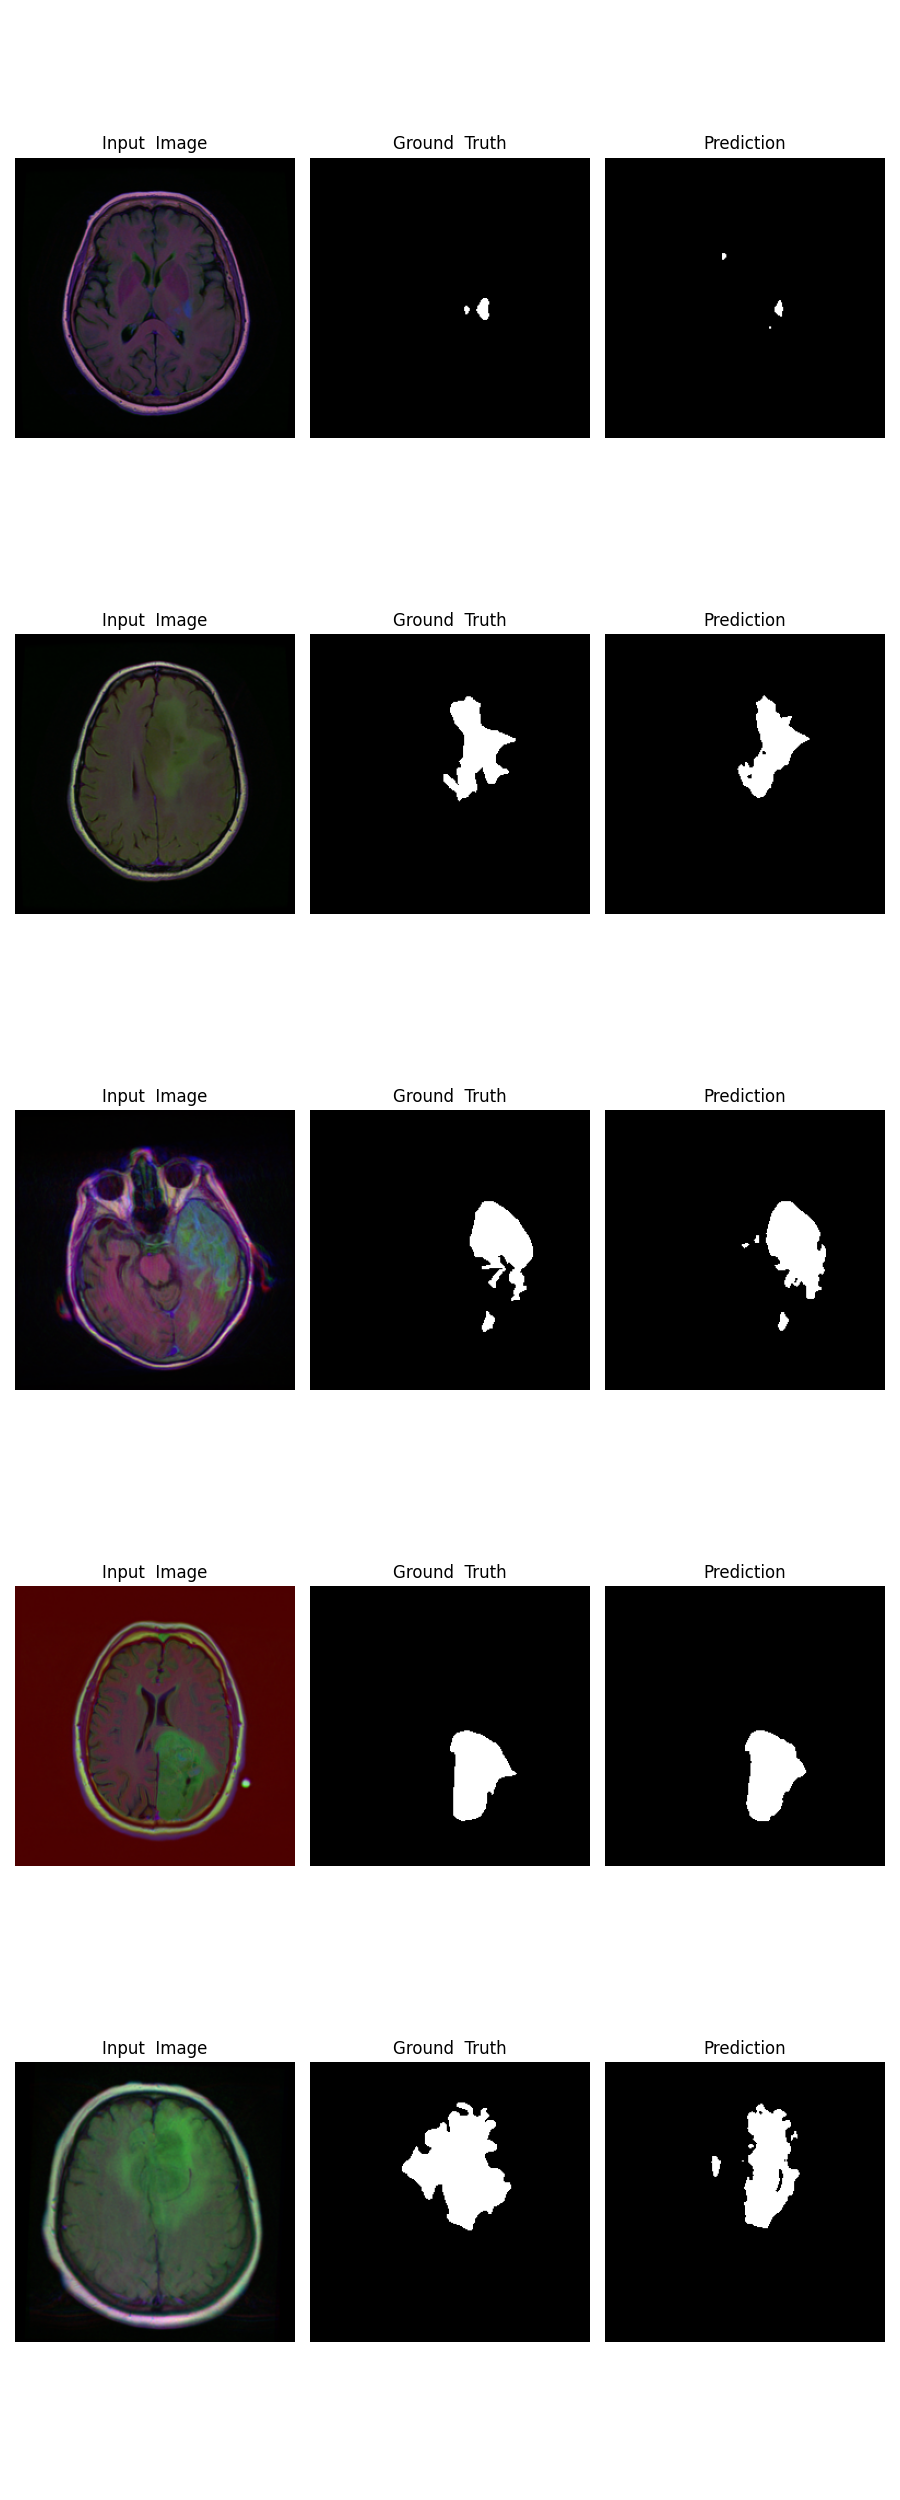

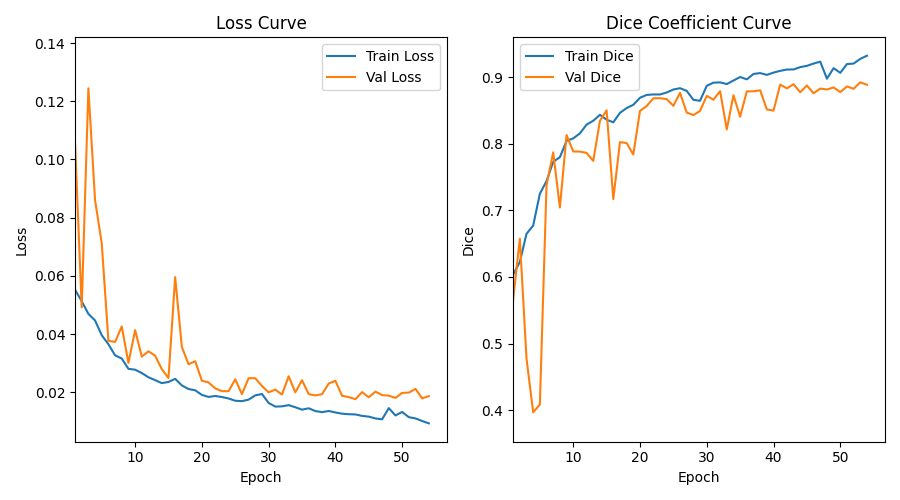

time: 18min 45s (started: 2025-07-09 00:00:37 +08:00)


In [8]:
# ====================== 5. 主程序 ======================
def main():
    """主训练流程"""
    # ===== 参数设置 =====
    # 主目录前缀
    base_dir = '/mnt/workspace'
    # 数据目录路径
    data_dir = base_dir+'/kaggle_3m'
    # 单次处理大小
    batch_size = 32
    # 训练轮数
    num_epochs = 55
    # 学习率
    lr = 0.009
    
    # 自动检测设备（优先使用GPU）
    device = torch.device('cuda'  if torch.cuda.is_available()  else 'cpu')
    print(f"Using device: {device}\n")
    
    # ===== 数据预处理 ===== 
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # 调整尺寸 
        transforms.ToTensor(),          # 转为Tensor并归一化到[0,1]
    ])
    # 创建数据集 
    train_dataset = BrainMRIDataset(data_dir, transform=transform, train=True)
    val_dataset = BrainMRIDataset(data_dir, transform=transform, train=False)
    
    # plt_pt = val_dataset.image_paths[0:3]
    # for pt in plt_pt:
    #     print(pt)
    
    # 创建数据加载器 
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, 
        shuffle=True, num_workers=4  # 多线程加载 
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, 
        shuffle=False, num_workers=4 
    )
    
    # ===== 初始化模型 ===== 
    model = UNet(n_channels=3, n_classes=1).to(device)
    # ===== 损失函数和优化器 ===== 
    criterion = nn.BCEWithLogitsLoss()  # 二分类交叉熵损失（带sigmoid）
    optimizer = torch.optim.Adam(model.parameters(),  lr=lr)
    # ===== 存储训练过程指标 =====
    train_losses, val_losses, train_dices, val_dices = [], [], [], []
    best_dice = 0.0

    for epoch in range(1,num_epochs+1):
        logc(f'Epoch {epoch}/{num_epochs}')
        # 训练阶段
        train_loss, train_dice = train_epoch(model, device, train_loader, optimizer, criterion, epoch)
        # 验证阶段
        val_loss, val_dice = validate(model, device, val_loader, criterion)

        # 实时输出
        print(f'Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f}')
        print(f'Val Loss: {val_loss:.4f}   | Val Dice: {val_dice:.4f}')

        # 保存最优模型
        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), 'best_model.pth')
            logc("Saved best model!", 'info')

        # 记录指标
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_dices.append(train_dice)
        val_dices.append(val_dice)
        logc(f"{'-' * 100}\n")
    
    logc(f'Best Dice: {best_dice:.4f}', 'red')
    # ===== 可视化结果 ===== 
    visualize_results(model, device, val_loader)
    plot_metrics(train_losses, val_losses, train_dices, val_dices)


if __name__ == '__main__':
    main()

In [9]:
# 避免IPython后台异常显存占用
# os.system('kill %d' % os.getpid())

time: 358 μs (started: 2025-07-09 00:19:25 +08:00)
